# Rectified Normalized Flow for Density Estimation

In [10]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

from torch.distributions.distribution import Distribution

import matplotlib.pyplot as plt

### Data

In [12]:
mu_1  = .1
mu_2  = .5
mu_3  = .9

sigma = 0.08

s_1 = np.random.normal(mu_1, sigma, 1000)
s_2 = np.random.normal(mu_2, sigma, 1000)
s_3 = np.random.normal(mu_3, sigma, 1000)

s = np.concatenate((s_1, s_2, s_3))

s = np.where(s < 0, 0., s)
s = np.where(s > 1, 1., s)

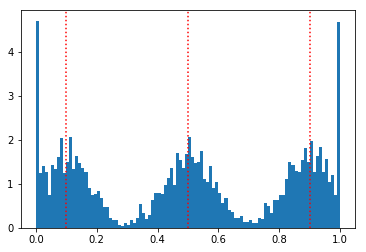

In [13]:
count, bins, ignored = plt.hist(s, 100, density=True)

plt.axvline(mu_1, linestyle=':', color='red')
plt.axvline(mu_2, linestyle=':', color='red')
plt.axvline(mu_3, linestyle=':', color='red')

plt.show()

## Model

In [3]:
class AutoregressiveLinear(nn.Module):
    """
    This layer realises linear transformations
        y = f(c, x)
    autoregressive in x, i.e. \pdv{y_i}{x_j} = 0 for i >= j, where
        x and y have the same dimensionality
        c is a context vector.

    The context vector is optional.
    """

    def __init__(self, output_size, context_size=0, bias=True):
        """
        Input size is output size plus context size.

        :param output_size:
        :param context_size:
        :param bias:
        """
        super(AutoregressiveLinear, self).__init__()

        self.context_size = context_size
        self.output_size = output_size
        self.input_size = context_size + output_size

        self.weight = nn.parameter.Parameter(torch.Tensor(self.output_size, self.input_size))
        if bias:
            self.bias = nn.parameter.Parameter(torch.Tensor(output_size))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        """Initializes the bias with zero, the weights with xavier/glorot normal."""
        # TODO: Use BNAF's initialisation
        self.weight = nn.init.xavier_normal_(self.weight)

        if self.bias is not None:
            self.bias.data.zero_()

    def forward(self, inputs, context=None):
        """Affine transformation with lower triangular weight matrix."""
        # Note that here I am zero-ing out the diagonal (necessary for the first MADE layer in an IAF)
        #  if you wanted to keep the diagonal you would need to do tril(0) or tril(context_units + 0) rather than -1
        if self.context_size == 0:
            return F.linear(inputs, self.weight.tril(-1), self.bias)
        else:  # outputs depend freely on the context units
            return F.linear(torch.cat([context, inputs], dim=-1), self.weight.tril(self.context_size - 1), self.bias)


In [7]:
class IAF(nn.Module):
    def __init__(self, latent_size):
        super(IAF, self).__init__()

        self.z_size = latent_size

        self.m = nn.Sequential(
            AutoregressiveLinear(self.z_size, self.z_size),
            nn.ELU(),
            AutoregressiveLinear(self.z_size, self.z_size),
            nn.ELU(),
            AutoregressiveLinear(self.z_size, self.z_size)
        )

        self.s = nn.Sequential(
            AutoregressiveLinear(self.z_size, self.z_size),
            nn.ELU(),
            AutoregressiveLinear(self.z_size, self.z_size),
            nn.ELU(),
            AutoregressiveLinear(self.z_size, self.z_size)
        )

    def forward(self, x, h=None):
        """
        :param z: An float tensor with shape of [batch_size, z_size]
        :return: An float tensor with shape of [batch_size, z_size] and log det value of the IAF mapping Jacobian
        """
        z = x
        
        m = self.m(z)
        s = self.s(z)

        z = s.exp() * z + m

        log_det = s.sum(1)

        return z, log_det

In [14]:
iaf       = IAF(latent_size=5)

epochs    = 10
data      = s
optimizer = optim.SGD(iaf.parameters(), lr=0.001)

In [ ]:
iaf.train()

for epoch in range(epochs):
    for x in data:
        z, log_det = iaf(x)
        
        

